In [ ]:
# !conda activate ai_workshop
!pip install -q neuraloperator
!git clone https://github.com/PolymathicAI/the_well
# we checkout this commit since the most recent ones all have one bug for data normalization
!cd the_well;git checkout e8a936f2e78b48dc62fc175df2e66d365e6bc6a9; pip install -q .


from the_well.data import WellDataset
from the_well.utils.download import well_download
base_path = './the_well/'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 49.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.9/186.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.5 MB/s eta

In [ ]:
# download and setup the dataset
well_download(base_path=base_path, dataset="turbulent_radiative_layer_2D", split='train')
well_download(base_path=base_path, dataset="turbulent_radiative_layer_2D", split='test')

In [ ]:

dataset_path = './the_well/datasets'
train_dataset = WellDataset(
    well_base_path=dataset_path,
    well_dataset_name="turbulent_radiative_layer_2D",
    well_split_name="train",
    n_steps_input=4,
    n_steps_output=1,
    use_normalization=True,
    # normalization_type=normalization.ZScoreNormalization,
)

test_dataset = WellDataset(
    well_base_path=dataset_path,
    well_dataset_name="turbulent_radiative_layer_2D",
    well_split_name="test",
    n_steps_input=4,
    n_steps_output=1,
    use_normalization=True,
    # normalization_type=normalization.ZScoreNormalization,
)


## One line description of the data

Everywhere in astrophysical systems hot gas moves relative to cold gas, which leads to mixing, and mixing populates intermediate temperature gas that is highly reactive—in this case it is rapidly cooling.

## Longer description of the data

In this simulation, there is cold, dense gas on the bottom and hot dilute gas on the top. They are moving relative to each other at highly subsonic velocities. This set up is unstable to the Kelvin Helmholtz instability, which is seeded with small scale noise that is varied between the simulations. The hot gas and cold gas are both in thermal equilibrium in the sense that the heating and cooling are exactly balanced. However, once mixing occurs as a result of the turbulence induced by the Kelvin Helmholtz instability the intermediate temperatures become populated. This intermediate temperature gas is not in thermal equilibrium and cooling beats heating. This leads to a net mass flux from the hot phase to the cold phase. This process occurs in the interstellar medium, and in the Circum-Galactic medium when cold clouds move through the ambient, hot medium. By understanding how the total cooling and mass transfer scale with the cooling rate we are able to constrain how this process controls the overall phase structure, energetics and dynamics of the gas in and around galaxies.
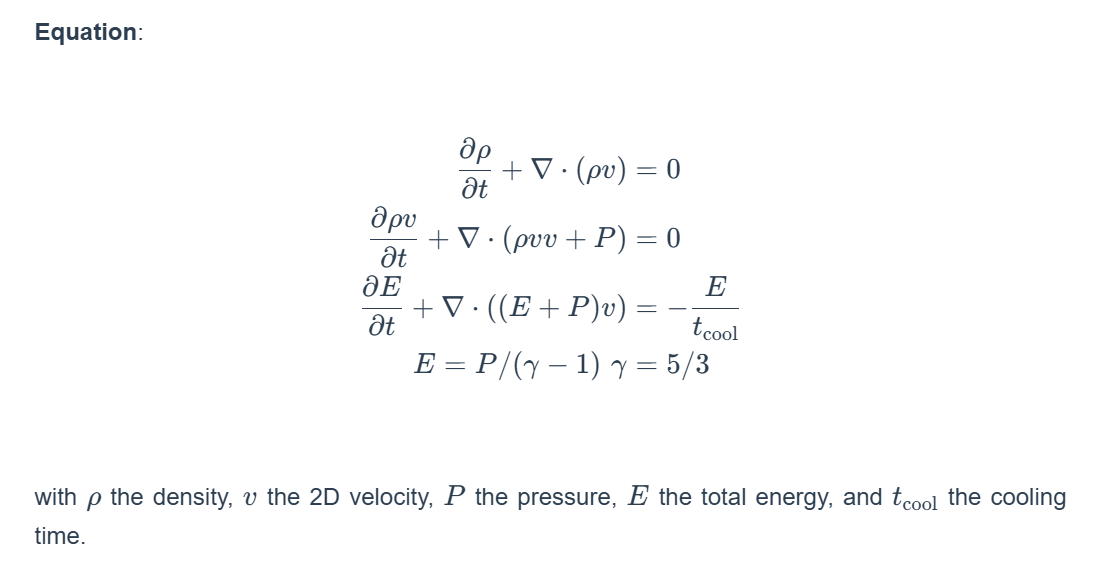


In [ ]:
# setup dataloader from the dataset
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
import einops
for batch in train_loader:
    break
for key in batch:
    print(f'Item : {key}, shape {batch[key].shape}')

def batch_parser(batch, device):
    inputs = batch['input_fields']
    outputs = batch['output_fields']

    inputs = einops.rearrange(inputs, 'N T H W C -> N (T C) H W')
    outputs = einops.rearrange(outputs, 'N T H W C -> N (T C) H W')
    return inputs.to(device), outputs.to(device)

for batch in train_loader:
    inputs, outputs = batch_parser(batch, 'cpu')
    break

Item : input_fields, shape torch.Size([16, 4, 128, 384, 4])
Item : output_fields, shape torch.Size([16, 1, 128, 384, 4])
Item : constant_scalars, shape torch.Size([16, 1])
Item : boundary_conditions, shape torch.Size([16, 2, 2])
Item : space_grid, shape torch.Size([16, 128, 384, 2])
Item : input_time_grid, shape torch.Size([16, 4])
Item : output_time_grid, shape torch.Size([16, 1])


![dataset](https://users.flatironinstitute.org/~polymathic/data/the_well/datasets/turbulent_radiative_layer_2D/gif/density_normalized.gif)

In [ ]:
import torch
from torch import nn
import numpy as np

import math

In [ ]:
def VRMSE(predictions, targets, mean=False):
    # VRMSE: sqrt(MSE / VAR)

    targets = targets.flatten(2)
    predictions = predictions.flatten(2)

    var = targets.var(-1) + 1e-5

    diff_sq = ((targets - predictions) ** 2).mean(-1)

    err = torch.sqrt(diff_sq / var)

    if mean:
        err = err.mean()

    return err


## Fourier Neural Operator (FNO)

FNO is another class of "neural operator" that was born for ai4science purpose.

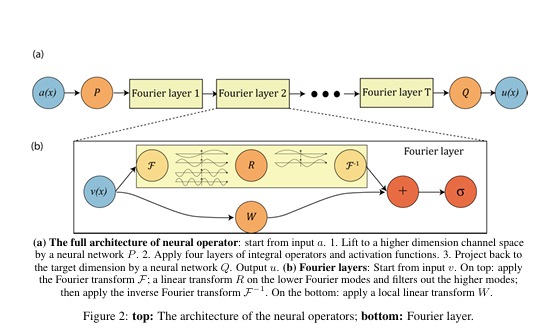

The key component, called FNO block, is a linear transform in the Fourier domain plus the residual connection.

## Lets do a shape analysis of FNO.

Given an image of shape `BHWC`, as (batch, height, width, channel)

1. A projection layer project it to `BHWF`, where the `F` is the hidden feature dimension that is often larger than the original number of channels.

2. In each block, block input $v(x)$ with shape `BHWF` is first transformed by FFT to `BH(W//2)F`, then truncated to `B(2M)MF`, where `M` is some hyperparameter to help remove high frequency artifact.

3. The FFT results undergoes a fully dense linear transformer to `B(2M)MF`, and is then padded with zero to `BH(W//2)F`.

4. An inverse FFT transforms it back to the original shape `BHWF`.




You can use `neuralop.models.FNO` once you are familiar with the package.

In [ ]:
class SpectralConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super().__init__()
        self.kernel_params = nn.Parameter(torch.randn(4, in_channels, out_channels, *modes) / (math.sqrt((in_channels + out_channels)/2)))
        # for some reason I have to do this additional line to register the parameter
        # self.register_parameter('kernel_params', self.kernel_params)
        self.mode0, self.mode1 = modes


    def forward(self, x):

        x_fft = torch.fft.rfftn(x, dim=(-3,-1))
        fft_shape = x_fft.shape

        x_fft_upper = x_fft[...,:self.mode0, :self.mode1]
        x_fft_lower = x_fft[...,-self.mode0:, :self.mode1]

        kernel_upper_img, kernel_lower_img, kernel_upper_real, kernel_lower_real = self.kernel_params

        # frequency-wise mixing of information

        x_fft_upper = torch.einsum(
            '...chw,cohw->...ohw',
            x_fft_upper,
            kernel_upper_real + kernel_upper_img * 1j,

        )

        x_fft_lower = torch.einsum(
            '...chw,cohw->...ohw',
            x_fft_lower,
            kernel_lower_real + kernel_lower_img * 1j,

        )

        x_fft_out = torch.zeros(fft_shape, device=x.device, dtype=x_fft.dtype)

        x_fft_out[...,:self.mode0, :self.mode1] = x_fft_upper

        x_fft_out[...,-self.mode0:, :self.mode1] = x_fft_lower

        return torch.fft.irfftn(x_fft_out, dim=(-2, -1))





5. Meanwhile, the block input $v(x)$ undergoes a pointwise transform to `BHWF`.

6. The point-wise transformed input and the FFT/inverse FFT transformed result are added togther and their sum pass through a non-linearity, usually ReLU function, to be the input to the next block.

7. By the end the block output is projected back to the desired number of channel `BHWD`.

In [ ]:
class FNOBlock2D(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super().__init__()
        self.spectral_conv = SpectralConv2D(in_channels, out_channels, modes)
        self.conv1x1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1,1))

    def forward(self, x):

        y = self.spectral_conv(x)

        x = self.conv1x1(x)
        return torch.nn.functional.relu(x + y)

class FNO(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, modes, num_layers):

        super().__init__()

        self.in_proj = nn.Conv2d(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=(1,1)

        )



        self.blocks = nn.ModuleList(
            [FNOBlock2D(in_channels=hidden_channels, out_channels=hidden_channels, modes=modes) for _ in range(num_layers)]
        )

        self.out_mlp=nn.Sequential(
            nn.Conv2d(in_channels = hidden_channels, out_channels = hidden_channels, kernel_size=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_channels, out_channels = out_channels, kernel_size=(1,1))
        )

    def forward(self,x):
        x = self.in_proj(x)

        for block in self.blocks:
            x = block(x)

        return self.out_mlp(x)

In [ ]:
# from neuralop.models import FNO
# fno = FNO(n_modes=(16, 16), hidden_channels=64, in_channels=inputs.shape[1], out_channels=outputs.shape[1]).to('cuda')


for batch in train_loader:
    inputs, outputs = batch_parser(batch, device)
    break

fno = FNO(in_channels=inputs.shape[1], hidden_channels=64, out_channels=outputs.shape[1], modes=(16,16), num_layers=6).to(device)
fno_optimizer = torch.optim.AdamW(params = fno.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.MSELoss()

for n, p in fno.named_parameters():
    print(n, 'device', p.device, 'requires_grad', p.requires_grad)

in_proj.weight device cuda:0 requires_grad True
in_proj.bias device cuda:0 requires_grad True
blocks.0.spectral_conv.kernel_params device cuda:0 requires_grad True
blocks.0.conv1x1.weight device cuda:0 requires_grad True
blocks.0.conv1x1.bias device cuda:0 requires_grad True
blocks.1.spectral_conv.kernel_params device cuda:0 requires_grad True
blocks.1.conv1x1.weight device cuda:0 requires_grad True
blocks.1.conv1x1.bias device cuda:0 requires_grad True
blocks.2.spectral_conv.kernel_params device cuda:0 requires_grad True
blocks.2.conv1x1.weight device cuda:0 requires_grad True
blocks.2.conv1x1.bias device cuda:0 requires_grad True
blocks.3.spectral_conv.kernel_params device cuda:0 requires_grad True
blocks.3.conv1x1.weight device cuda:0 requires_grad True
blocks.3.conv1x1.bias device cuda:0 requires_grad True
blocks.4.spectral_conv.kernel_params device cuda:0 requires_grad True
blocks.4.conv1x1.weight device cuda:0 requires_grad True
blocks.4.conv1x1.bias device cuda:0 requires_grad T

In [ ]:
num_epoch = 5
counter = 0

for e in range(num_epoch):


    fno = fno.train()

    train_loss_cum = []
    train_err_cum = []

    for step, batch in enumerate(train_loader):
        inputs, outputs = batch_parser(batch, device)
        fno_optimizer.zero_grad()

        predictions = fno(inputs)


        loss = criterion(predictions, outputs)
        train_loss_cum.append(loss.detach().cpu())

        vrmse = VRMSE(predictions, outputs, mean=True)

        train_err_cum.append(vrmse.detach().cpu())

        loss.backward()
        fno_optimizer.step()

        current_train_loss = torch.tensor(train_loss_cum).mean().item()
        current_train_err = torch.tensor(train_err_cum).mean().item()
        counter += 1
        if step % (len(train_loader) // 10) == 0:
        # if step % 100 == 0:
            inputs = inputs.cpu()[0]
            predictions = predictions.detach().cpu()[0]

            print(f'Epoch {e} / {num_epoch}, step {step} / {len(train_loader)}, train loss : {current_train_loss:.4f}, train error: {current_train_err:.4f}')




    train_loss_cum = torch.tensor(train_loss_cum).mean().item()

    test_err_cum = []

    with torch.no_grad():
        fno = fno.eval()

        for batch in test_loader:
            inputs, outputs = batch_parser(batch, device)
            inputs = inputs.to(device)
            predictions = fno(inputs)
            vrmse = VRMSE(predictions, outputs, mean=True)
            test_err_cum.append(vrmse.detach().cpu())
    test_err_cum = torch.tensor(test_err_cum).mean().item()
    print('=============================================================================================')
    print(f'Epoch {e} / {num_epoch} test error: {test_err_cum:.4f}')

    outputs = outputs.detach().cpu()[0]
    predictions = predictions.detach().cpu()[0]

    plt.figure(figsize=(40, 4))

    plt.subplot(1,3,1)
    plt.imshow(outputs[0])
    plt.axis('off')
    plt.colorbar()
    plt.title('Target')
    plt.tight_layout()

    plt.subplot(1,3,2)
    plt.imshow(predictions[0])
    plt.title(f'Prediction at Epoch {e} / {num_epoch}')
    plt.axis('off')
    plt.colorbar()
    plt.tight_layout()

    plt.subplot(1,3,3)
    plt.imshow(outputs[0] - predictions[0])
    plt.title(f'Error at Epoch {e} / {num_epoch}')
    plt.axis('off')
    plt.colorbar()
    plt.tight_layout()

    plt.show()
    plt.close()

    print('=============================================================================================')



Output hidden; open in https://colab.research.google.com to view.